## Price movement from 2:00PM to 2:30PM

In [23]:
# Idea
# Khoang cach(bar) tu cay nen 2h den cay nen cao nhat va thap nhat trong ngay(2 cases: truoc va sau 2h)
# Percent price giua gia luc 2h va gia cao nhat, thap nhat trong ngay
# Su phu thuoc cua return vao 2 yeu to tren

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

import warnings
warnings.filterwarnings('ignore')

In [25]:
from sklearn.cluster import KMeans

In [26]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [27]:
data = dataset.copy()

In [28]:
### Ignore this year data => tranh over fitting
# data = data[data.index < '2024-01-01 00:00:00']
data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')].copy()

In [29]:
def cal_first_close(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 915]
  if not tick.empty:
    return tick[0]


def cal_high_before(tick):
  tick = tick[100*tick.index.hour+tick.index.minute < 1345]
  return tick.max()

def cal_high_after(tick):
  tick = tick[100*tick.index.hour+tick.index.minute > 1345]
  tick = tick[100*tick.index.hour+tick.index.minute < 1430]
  return tick.max()


def cal_low_before(tick):
  tick = tick[100*tick.index.hour+tick.index.minute < 1355]
  return tick.min()


def cal_low_after(tick):
  tick = tick[100*tick.index.hour+tick.index.minute > 1355]
  tick = tick[100*tick.index.hour+tick.index.minute < 1430]
  return tick.min()


def cal_price(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1355]
  if not tick.empty:
    return tick[0]

def cal_close(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1425]
  if not tick.empty:
    return tick[0]
      
def cal_last(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1445]
  if not tick.empty:
    return tick[0]

In [30]:
data['first_close'] = data.Close
data['price'] = data.Close
data['_last'] = data.Close
data['prev_high'] = data.High
data['prev_low'] = data.Low
data['next_high'] = data.High
data['next_low'] = data.Low
price = data.resample("D").agg({
    'first_close': cal_first_close,
    'prev_high':cal_high_before,
    'prev_low': cal_low_before,
    'next_high':cal_high_after,
    'next_low': cal_low_after,
    'price': cal_price,
    'Close': cal_close,
    '_last': cal_last
    })
price = price.dropna()

In [31]:
price

,first_close,prev_high,prev_low,next_high,next_low,price,Close,_last
Date,,,,,,,,
2020-11-02,898.6,901.5,895.4,907.0,896.6,902.0,907.0,904.0
2020-11-03,908.5,910.8,903.7,910.4,904.1,905.8,908.5,908.3
2020-11-04,908.6,914.6,906.7,918.1,910.2,916.3,913.5,912.3
2020-11-05,913.1,919.9,912.4,918.3,910.0,915.3,910.8,910.2
2020-11-06,911.4,912.0,903.3,912.7,907.3,907.3,910.0,908.3
...,...,...,...,...,...,...,...,...
2024-09-24,1324.8,1329.2,1322.2,1335.1,1326.5,1328.8,1335.1,1335.0
2024-09-25,1339.3,1349.9,1336.9,1346.4,1341.5,1343.4,1344.4,1344.0
2024-09-26,1347.7,1361.3,1345.2,1366.5,1357.2,1363.6,1358.6,1356.4


In [32]:
len(price[(price.next_high - price.price > 0) & (price.price - price.next_low > 0)])

932

In [33]:
len(price[(price.next_high - price.price > 3) & (price.price - price.next_low > 3)])

270

In [34]:
# mom_y = momentum_yesterday
price['mom_y'] = 100 * (price.price - price._last.shift(1)) / price._last.shift(1)
price['body_rate'] = (price.price - price.first_close) / (price.prev_high - price.prev_low)
price['return'] = 1000 * (price.Close - price.price) / price.price
price['next_high_rate'] = 1000 * (price.next_high - price.price) / price.price
price['next_low_rate'] = 1000 * (price.next_low - price.price) / price.price

In [35]:
price

,first_close,prev_high,prev_low,next_high,next_low,price,Close,_last,mom_y,body_rate,return,next_high_rate,next_low_rate
Date,,,,,,,,,,,,,
2020-11-02,898.6,901.5,895.4,907.0,896.6,902.0,907.0,904.0,NaN,0.557377,5.543237,5.543237,-5.986696
2020-11-03,908.5,910.8,903.7,910.4,904.1,905.8,908.5,908.3,0.199115,-0.380282,2.980790,5.078384,-1.876794
2020-11-04,908.6,914.6,906.7,918.1,910.2,916.3,913.5,912.3,0.880766,0.974684,-3.055768,1.964422,-6.657208
2020-11-05,913.1,919.9,912.4,918.3,910.0,915.3,910.8,910.2,0.328839,0.293333,-4.916421,3.277614,-5.790451
2020-11-06,911.4,912.0,903.3,912.7,907.3,907.3,910.0,908.3,-0.318611,-0.471264,2.975862,5.951725,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-24,1324.8,1329.2,1322.2,1335.1,1326.5,1328.8,1335.1,1335.0,0.248963,0.571429,4.741120,4.741120,-1.730885
2024-09-25,1339.3,1349.9,1336.9,1346.4,1341.5,1343.4,1344.4,1344.0,0.629213,0.315385,0.744380,2.233140,-1.414322
2024-09-26,1347.7,1361.3,1345.2,1366.5,1357.2,1363.6,1358.6,1356.4,1.458333,0.987578,-3.666764,2.126723,-4.693458


### Estimated return - distribution

In [36]:
price['return'].describe()

count    974.000000
mean      -0.232136
std        6.292892
min      -27.832377
25%       -3.410005
50%        0.092831
75%        3.001141
max       28.491097
Name: return, dtype: float64

## Quantile

In [37]:
deq_low = price["mom_y"].quantile(0.01)
deq_high  = price["mom_y"].quantile(0.99)
dvq_low = price["body_rate"].quantile(0.01)
dvq_high  = price["body_rate"].quantile(0.99)
signal_data = price[(price["mom_y"] < deq_high) & (price["mom_y"] > deq_low) & (price["body_rate"] < dvq_high) & (price["body_rate"] > dvq_low)]

In [38]:
feature_cols = ["body_rate", "mom_y"]
cluster = KMeans(n_clusters=20, n_init=2).fit(signal_data[feature_cols])
signal_data = signal_data.assign(cluster=cluster.labels_)

<Axes: xlabel='cluster'>

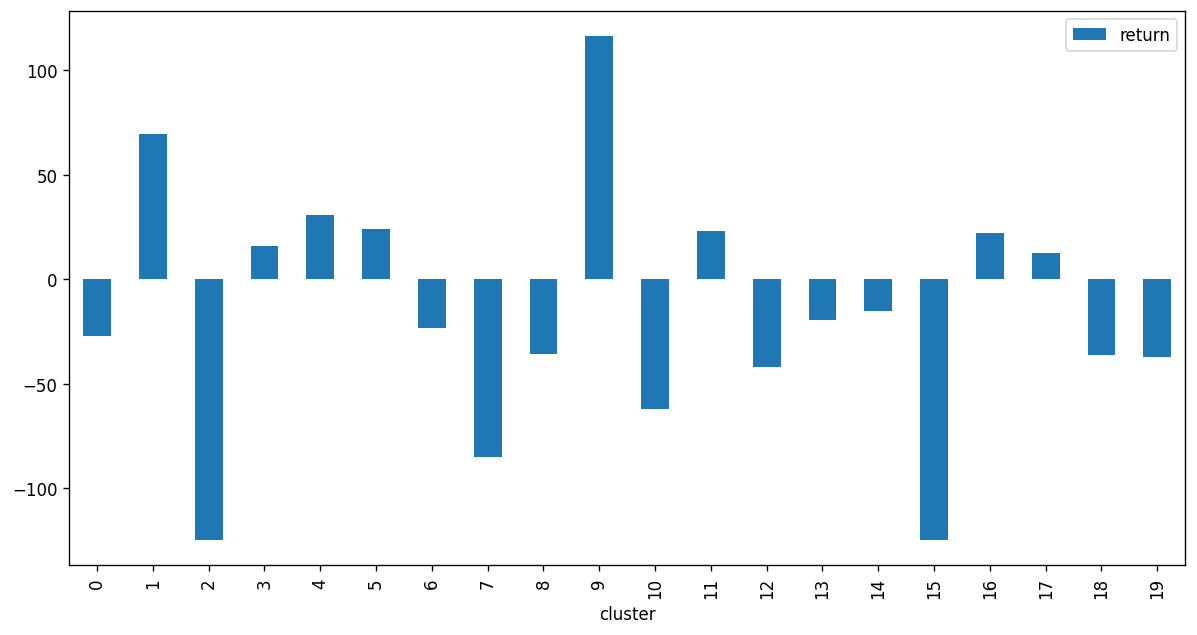

In [39]:
group_by_cluster = signal_data.groupby(['cluster'])[['return']].sum()
group_by_cluster.plot.bar()

<Axes: xlabel='cluster'>

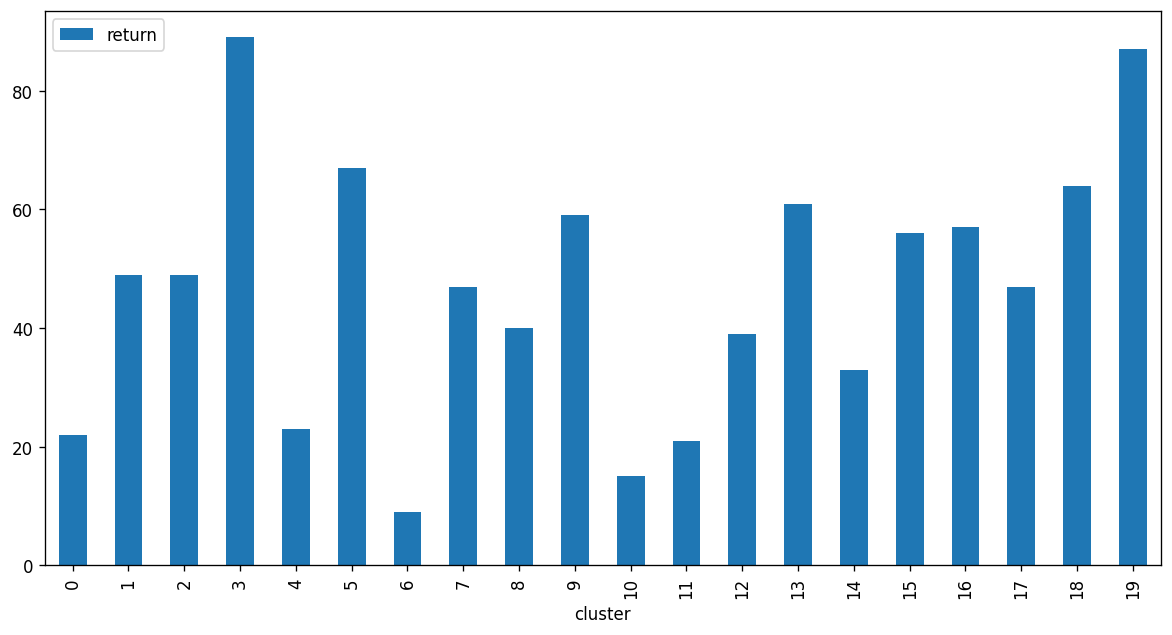

In [41]:
group_by_clusterc = signal_data.groupby(['cluster'])[['return']].count()
group_by_clusterc.plot.bar()

In [42]:
group_by_clusterc

,return
cluster,
0,22
1,49
2,49
3,89
4,23
5,67
6,9
7,47
8,40


<Axes: xlabel='cluster'>

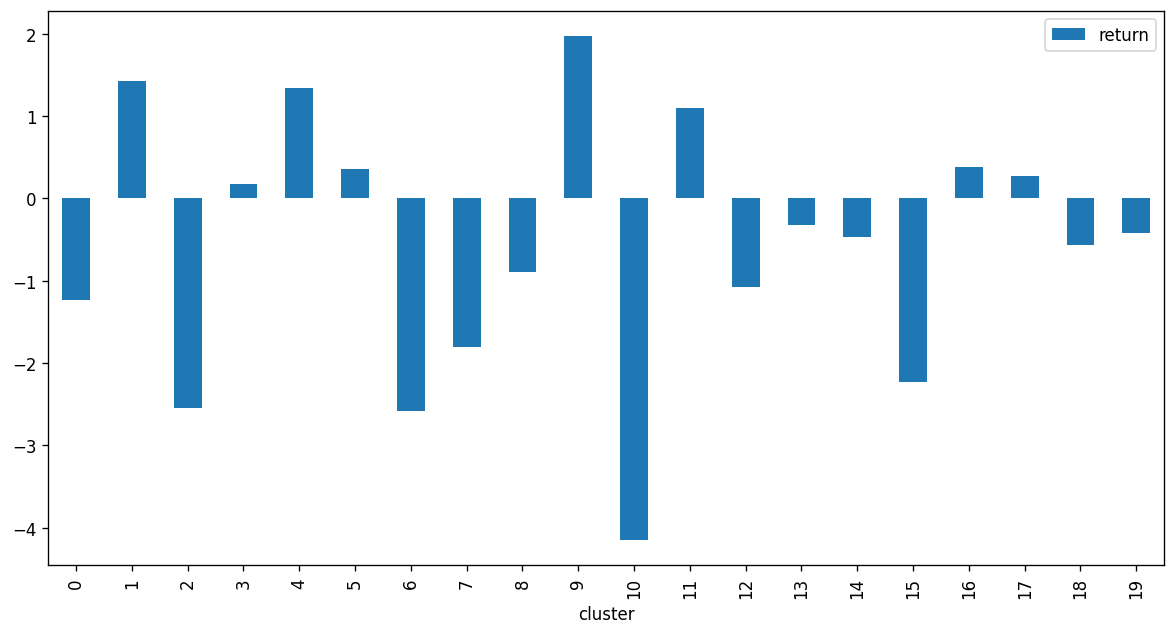

In [43]:
group_by_clusterm = signal_data.groupby(['cluster'])[['return']].mean()
group_by_clusterm.plot.bar()